### Importing of necessary libraries and initializing scientific constants

In [2]:
from scipy import constants
import numpy as np
import math
import matplotlib.pyplot as plt
import time 
import matplotlib.patches as patches

#Defining the constants
c_0 = constants.speed_of_light
mu_0 = constants.mu_0
epsilon_0 = constants.epsilon_0


### Plotting Functions

In [34]:
def plot_single(x=0,y1=0,y2=0,size=[18,12],labels=["X-Axis","Y-Axis","Title"]):
    """
    Plot a vector in a single time step (snapshot in time)
    """
    plt.figure(figsize = size)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[2])
    plt.plot(x,y1)
    #plt.plot(x,y2)
    plt.savefig(f"./source_{labels[2]}.jpeg")
    plt.show()

def plot_fields(z,E_plot,H_plot,N_t,injection_point,title="",save=False):
    plt.ion()
    fig = plt.figure(1,[10,6])
    ax = fig.add_subplot(111)
    plt.ylabel("Value")
    
    _,x = E_plot.shape
    #Draw computational domain
    plt.axhline(y=0,color="black",linestyle = "-")
    plt.axvline(x=injection_point, color = "grey", linestyle="--")
    ax.add_patch(Rectangle(()))
    plt.xlabel("z (Space)")
    plt.ylim((-5,5))
    #plt.xlim((0,x))
    lineE, = ax.plot(E_plot[0,:])
    lineH, = ax.plot(H_plot[0,:])
    fig.show()

    for i in range(1,N_t):
        plt.ylim(-5,5)
        plt.legend(handles = [lineE,lineH],labels=["Electric Field","Magnetic Field"])
        print(f"Currently plotting Iteration step: {i}/{N_t}")
        plt.title(f'FDTD 1-D {title} | Iteration step: {i}/{N_t}')
        if save == True:
            plt.savefig("/home/user/Desktop/photos/1d-fdtd{num:07d}.jpeg".format(num=i))
        lineE.set_ydata(E_plot[i,:])
        lineH.set_ydata(H_plot[i,:])
        fig.canvas.draw()
        fig.canvas.flush_events()

### User Input

In [37]:
#User Input
f_max = float(input("Enter the max frequency of the source excitation (in Hz): "))
mode = int(input("Enter the mode of FDTD Algorithm: \n(1) Basic Algorithm, No source excitation\n(2) Algorithm with Hard Source\n(3) Algorithm with Soft Source\n(4) Algorithm with Soft Source (with PABC)\n(5) Algorithm with TF/SF (with PABC):"))
source = int(input("Enter what source excitation to use: (1) Gaussian Pulse\n(2) Sinusoidal Source: "))
#NOTE: The assumption in this code is that the computational domain is composed of free-space
#There is no other material present in the domain so the material properties are that of the free space

Enter the max frequency of the source excitation (in Hz): 2.4e9
Enter the mode of FDTD Algorithm: 
(1) Basic Algorithm, No source excitation
(2) Algorithm with Hard Source
(3) Algorithm with Soft Source
(4) Algorithm with Soft Source (with PABC)
(5) Algorithm with TF/SF (with PABC):1
Enter what source excitation to use: (1) Gaussian Pulse
(2) Sinusoidal Source: 2


### Computing Grid Resolution (for preventing Numerical Dispersion)

In [38]:
#Computing Grid Resolution
n_max = 1 #Due to free space
lambda_min = c_0/(f_max*n_max)
N_lambda = 10
delta_lambda = lambda_min/N_lambda
d_min = 0.01
delta_d = d_min/4 #The d_min is assumed to be 0.01 since there is no device in the domain
delta_init = min(delta_lambda,delta_d)
#Since there is currently no critical dimension in the domain, assume it is 0.7
spacers = 15
#d_critical = 0.7
#N_z = math.ceil(d_critical/delta_init) + spacers
N_z = 500 + spacers
delta_z = delta_init
z = np.linspace(0,N_z*delta_z,N_z)
print("=====================================================================")
print(f"Number of Yee cells: {N_z} cells\nLength of each cell (Delta_z): {delta_z} m")

Number of Yee cells: 515 cells
Length of each cell (Delta_z): 0.0025 m


### Computing Material Properties
Assumed to be all free space at the moment

In [39]:
#Computing material properties
mu_r = np.ones((N_z))    #Due to free space
epsilon_r = np.ones((N_z))
n_r = np.sqrt(mu_r[0]*epsilon_r[0])

### Gaussian and Sinusoidal Source Functions

In [40]:
def gaussian_source(f_max,t_prop,delta_t,delta_z,c_0):
    """
    Gaussian Pulse Source that is used for injecting source in 1D FDTD.
    """
    #Set source permittivity and permeability
    mu_src =1 #these parameters should be the material permittivity/permeability at the grid position of the source injection
    epsilon_src = 1

    #Computing source parameters
    tau = 0.5/f_max
    t_0 = 3*tau
    T = 6.5*tau #+ 5*t_prop #Total time of simulation
    N_t = math.ceil(T/delta_t) #Number of time steps
    t = np.linspace(0,N_t*delta_t,N_t)
    print("=======================================================================")
    #print(f"t_0 = {t_0} m, tau = {tau} m ")
    #print(f"t = {t}")
    n_src = np.sqrt(epsilon_src*mu_src)
    deltaT = (n_src*delta_z/2*c_0)+(delta_t/2)

    A = -np.sqrt(epsilon_src/mu_src)
    x_E = (t - t_0)/tau
    x_H = ((t + deltaT)-t_0)/tau

    Esrc = np.exp(-np.power(x_E,2),dtype=np.longdouble).astype('longdouble')
    Hsrc = A*np.exp(-np.power(x_H,2),dtype=np.longdouble).astype('longdouble')
    return Esrc,Hsrc,t,N_t

def sinusoidal_source(f_max,t_prop,delta_t,delta_z,c_0):
    #Set source permittivity and permeability
    mu_src =1 #these parameters should be the material permittivity/permeability at the grid position of the source injection
    epsilon_src = 1

    #Computing source parameters
    tau = 3/f_max
    t_0 = 3*tau
    T = 6.5*tau #+ 5*t_prop #Total time of simulation
    N_t = math.ceil(T/delta_t) #Number of time steps
    t = np.linspace(0,N_t*delta_t,N_t)

    n_src = np.sqrt(epsilon_src*mu_src)
    deltaT = (n_src*delta_z/2*c_0)+(delta_t/2)

    A = -np.sqrt(epsilon_src/mu_src)

    n, = t.shape
    Esrc = np.zeros((t.shape))
    Hsrc = np.zeros((t.shape))
    for i in range(n):
        x_E = (t[i] - t_0)/tau
        x_H = (t[i]-t_0 + deltaT)/tau
        if t[i] < t_0:
            AmpE = np.exp(-np.power(x_E,2))
            AmpH = np.exp(-np.power(x_H,2))
            Esrc[i] = AmpE*(np.sin(2*np.pi*f_max*t[i]))
            Hsrc[i] = AmpH*A*(np.sin(2*np.pi*f_max*t[i]))
        else:
            Esrc[i] = AmpE*(np.sin(2*np.pi*f_max*t[i]))
            Hsrc[i] = AmpH*A*(np.sin(2*np.pi*f_max*t[i]))
    return Esrc,Hsrc,t,N_t

### Computing Time Step and Source (for preventing Numerical Dispersion)

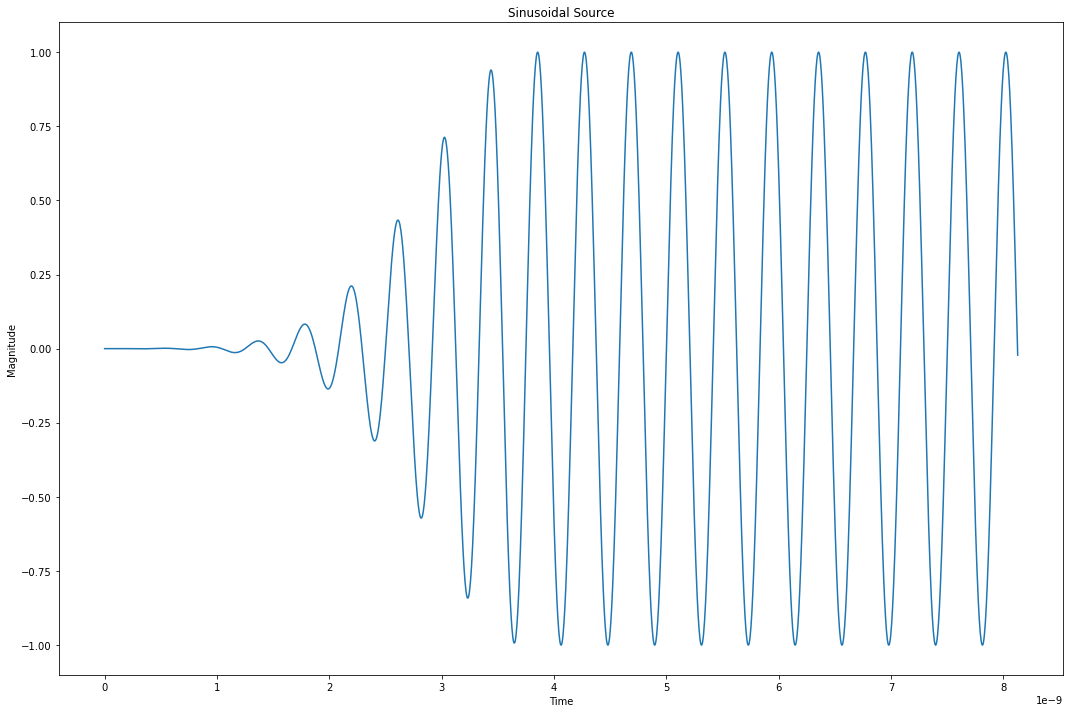

In [41]:
n_bc = 1 #Refractive index at the boundaries (assume free space) or min. refractive index in the domain
delta_t = (n_bc*delta_z)/(2*c_0) #Time step 
t_prop = (n_r*N_z*delta_z)/c_0 #time it takes to propagate in the domain

if source == 1:
    Esrc,Hsrc,t,N_t = gaussian_source(f_max,t_prop,delta_t,delta_z,c_0)
elif source == 2:
    Esrc,Hsrc,t,N_t = sinusoidal_source(f_max,t_prop,delta_t, delta_z, c_0)

injection_point = math.floor(N_z/4) #Set this before the device/model in the domain
print("=====================================================================")
#print(f"Time step: {delta_t} seconds")
#print(f"Number of iterations: {N_t} steps")
#print(f"Time vector: {t.shape} [Shape]")
#print(f"E-Field (Source):{Esrc.shape} dtype = {Esrc.dtype}, H-Field (Source): {Hsrc.shape} dtype = {Hsrc.dtype}")
#print(f"E={Esrc}, H={Hsrc}")
if source == 1:
    plot_single(t,Esrc,Hsrc,labels=["Time","Magnitude","Gaussian Pulse Source"])
elif source == 2:
    plot_single(t,Esrc,Hsrc,labels=["Time","Magnitude","Sinusoidal Source"])

### Update coefficient computations and Field initialization

In [8]:
# Computing the update coefficients
m_E = c_0*delta_t/(epsilon_r*delta_z) #This is assuming that every cell is in free space
m_H = c_0*delta_t/(mu_r*delta_z)

#Field initialization
E = np.zeros((N_z),dtype=np.longdouble)
H = np.zeros((N_z),dtype=np.longdouble)
print("=====================================================================")
print(f"Update coefficients: m_E = {m_E.shape}, m_H = {m_H.shape}")
print(f"Field vectors: Ey: {E.shape} dtype = {E.dtype}, Hx: {H.shape} dtype = {H.dtype}")

#Initialize Boundary Terms (For Perfect Absorbing Boundary Conditions)
z_low = [0,0]
z_high = [0,0]
e2 = 0
h2 = 0

#Initialize save matrix
E_plot = np.zeros((N_t,N_z))
H_plot = np.zeros((N_t,N_z))

plot_title = ""

Update coefficients: m_E = (515,), m_H = (515,)
Field vectors: Ey: (515,) dtype = float64, Hx: (515,) dtype = float64


In [9]:
if mode == 3: #Algorithm with Soft Source
    plot_title = "Soft Source"
    #Loop in time for Algorithm
    for i in range(N_t):
        #Update H from E (loop in space)
        for k in range(N_z -1): #Leave out the last cell @ index=N_z-1 for the boundary condition
            H[k] = H[k] + m_H[k]*(E[k+1] - E[k])
        #Dirichlet Boundary Condition for H at the end of the grid
        H[N_z-1] = H[N_z-1] + m_H[N_z-1]*(0 - E[N_z-1])

        #Dirichlet Boundary Condition for E at the start of the grid
        E[0] = E[0] + m_E[0]*(H[0]-0)
        #Update E from H (loop in space)
        for k in range(1,N_z):
            E[k] = E[k] + m_E[k]*(H[k]-H[k-1])

        #Inserting source excitation (Soft Source)
        E[injection_point] = E[injection_point] + Esrc[i]

        #Save into matrix
        E_plot[i,:] = E.reshape((1,N_z))
        H_plot[i,:] = H.reshape((1,N_z))
        print("=====================================================================")
        print(f"FDTD Algorithm {plot_title}: Successfully computed field values! iteration: {i}/{N_t}")
        
elif mode == 5: #Algorithm with TF/SF (with PABC)
    plot_title = "TF/SF with PABC"
    #Loop in time for Algorithm
    for i in range(N_t):

         #Record H at Boundary
        h2 = z_low.pop(0)
        z_low.append(H[0])

        #Update H from E (loop in space)
        for k in range(N_z -1): #Leave out the last cell @ index=N_z-1 for the boundary condition
            H[k] = H[k] + m_H[k]*(E[k+1] - E[k])
            
        #Adjustments for TF/SF
        #At k_injection - 1...
        H[injection_point-1] = H[injection_point-1] - m_H[injection_point-1]*Esrc[i]

        # Perfect Absorbing Boundary Condition for H at the end of the grid
        H[N_z-1] = H[N_z-1] + m_H[N_z-1]*(e2 - E[N_z-1])

        #Record E at Boundary
        e2 = z_high.pop(0)
        z_high.append(E[N_z-1])

        # Perfect Absorbing Boundary Condition for E at the start of the grid
        E[0] = E[0] + m_E[0]*(H[0]-h2)
        #Update E from H (loop in space)
        for k in range(1,N_z):
            E[k] = E[k] + m_E[k]*(H[k]-H[k-1])

        #Adjustment for the TF/SF
        E[injection_point] = E[injection_point] - m_E[injection_point]*Hsrc[i-1]
      
        
        
        #Save into matrix
        E_plot[i,:] = E.reshape((1,N_z))
        H_plot[i,:] = H.reshape((1,N_z))
        print("=====================================================================")
        print(f"FDTD Algorithm {plot_title}: Successfully computed field values! iteration: {i}/{N_t}")
        print(f"z_low:{z_low}")
        print(f"z_high:{z_high}")
elif mode == 6:
    plot_title = "TFSF No Space Loop"
    #Loop in time for Algorithm
    for i in range(N_t):

        #Update H from E (loop in space)
        H[:-1] = H[:-1] + m_H[:-1]*(E[1:]-E[:-1])
        
        #Dirichlet Boundary Condition for H at the end of the grid
        H[N_z-1] = H[N_z-1] + m_H[N_z-1]*(0 - E[N_z-1])
        
        #H[injection_point-1] += Hsrc[i]
        # #TFSF of Magnetic Field 
        H[injection_point-1] -= m_H[injection_point -1]*Hsrc[i]
        
        #Dirichlet Boundary Condition for E at the start of the grid
        E[0] = E[0] + m_E[0]*(H[0]-0)

        #Update E from H (loop in space)
        E[1:] = E[1:] + m_E[1:]*(H[1:]-H[:-1])
        
        #TFSF of Electric Field
        #Inserting source excitation (Soft Source)
        E[injection_point] -= m_E[injection_point]*Esrc[i]

        #Save into matrix
        E_plot[i,:] = E.reshape((1,N_z))
        H_plot[i,:] = H.reshape((1,N_z))
        print("=====================================================================")
        print(f"FDTD Algorithm {plot_title}: Successfully computed field values! iteration: {i}/{N_t}")



FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 0/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 6/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 7/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 8/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 9/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 10/5750
FDTD Algorithm TFSF 

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 451/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 452/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 453/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 454/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 455/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 456/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 457/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 458/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 459/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 460/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 461/5750

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 885/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 886/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 887/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 888/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 889/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 890/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 891/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 892/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 893/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 894/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 895/5750

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1365/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1366/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1367/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1368/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1369/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1370/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1371/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1372/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1373/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1374/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1835/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1836/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1837/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1838/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1839/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1840/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1841/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1842/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1843/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 1844/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2271/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2272/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2273/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2274/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2275/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2276/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2277/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2278/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2279/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2280/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2686/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2687/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2688/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2689/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2690/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2691/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2692/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2693/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2694/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 2695/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3014/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3015/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3016/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3017/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3018/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3019/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3020/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3021/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3022/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3023/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3450/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3451/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3452/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3453/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3454/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3455/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3456/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3457/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3458/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3459/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3905/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3906/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3907/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3908/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3909/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3910/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3911/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3912/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3913/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 3914/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4380/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4381/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4382/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4383/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4384/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4385/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4386/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4387/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4388/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4389/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4823/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4824/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4825/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4826/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4827/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4828/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4829/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4830/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4831/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 4832/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5294/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5295/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5296/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5297/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5298/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5299/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5300/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5301/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5302/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration: 5303/5750
FDTD Algorithm TFSF No Space Loop: Successfully computed field values! iteration

### Plotting the fields

<IPython.core.display.Javascript object>


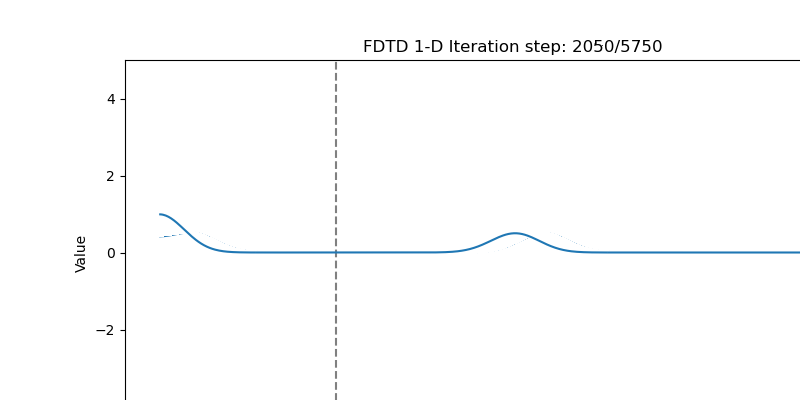

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-10-af9b2e67285a>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

KeyboardInterrupt: 

In [10]:
#Plotting the field values....
%matplotlib notebook
fig = plt.figure(1,[10,5])
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,N_t):
    lineE = E_plot[i,:]
    #lineH = H_norm_plot[i,:]
    ax.clear()
    #plt.legend(handles = [lineE,lineH],labels=["Electric Field","Magnetic Field"])
    plt.ylabel('Value')
    plt.axvline(x=injection_point, color = "grey", linestyle="--")
    plt.ylim(-5,5)
    plt.xlabel('z (Space)')
    #plt.ylimit([-3,3])/
    plt.title(f'FDTD 1-D Iteration step: {i}/{N_t}')
    ax.plot(lineE)
    #ax.plot(lineH)
    fig.canvas.draw()
    #plt.savefig(f"1d-fdtd{i}.jpeg")
    ax = plt.axes()
    